In [1]:
%run setup.ipynb

In [2]:
callset_phased = phase1_ar31.callset_phased
callset_phased

<HDF5 file "ag1000g.phase1.ar3.1.haplotypes.h5" (mode r)>

In [3]:
df_haps = phase1_ar31.df_haplotypes
df_haps.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


In [4]:
ihs_raw = phase1_selection.ihs_raw
ihs_raw

Group(/, 5)
  groups: 5; 2L, 2R, 3L, 3R, X
  store: DirectoryStore

In [5]:
def build_dataframe(pop, seqid=None, window_size=100):
    
    if seqid is None:
        df = pd.concat([build_dataframe(pop, seqid=seqid, window_size=window_size) for seqid in seqids])
        return df
        
    # extract raw values
    grp = ihs_raw[seqid][pop]
    pos = grp['POS'][:]
    values = np.abs(grp['iHS_gw_std'][:])
    nomiss = ~np.isnan(values)
    pos_nomiss = pos[nomiss]
    values_nomiss = values[nomiss]
    
    # construct moving windows
    starts_col = allel.moving_statistic(pos_nomiss, statistic=lambda v: v[0], size=window_size)
    starts_col[0] = 1  # fix to start of sequence
    ends_col = np.append(starts_col[1:] - 1, [len(genome[seqid])])
    
    # summarise values in windows
    values_col = allel.moving_statistic(values_nomiss, statistic=np.max, size=window_size)
    
    # seqid column
    seqid_col = np.array([seqid] * len(starts_col))
    
    # build dataframe
    df = pd.DataFrame.from_items([
        ('seqid', seqid_col), 
        ('start', starts_col), 
        ('end', ends_col), 
        ('value', values_col)
    ])
    return df


In [46]:
df = build_dataframe('BFS', window_size=100)
df.head()

,seqid,start,end,value
0,2R,1,40885,1.725094
1,2R,40886,60156,1.692042
2,2R,60157,82675,1.982869
3,2R,82676,94962,1.847272
4,2R,94963,106533,1.736274


In [47]:
starts, ends, values, percentiles = peakfit.extract_windowed_values(df, seqid=('2R', '2L'), genome=genome)

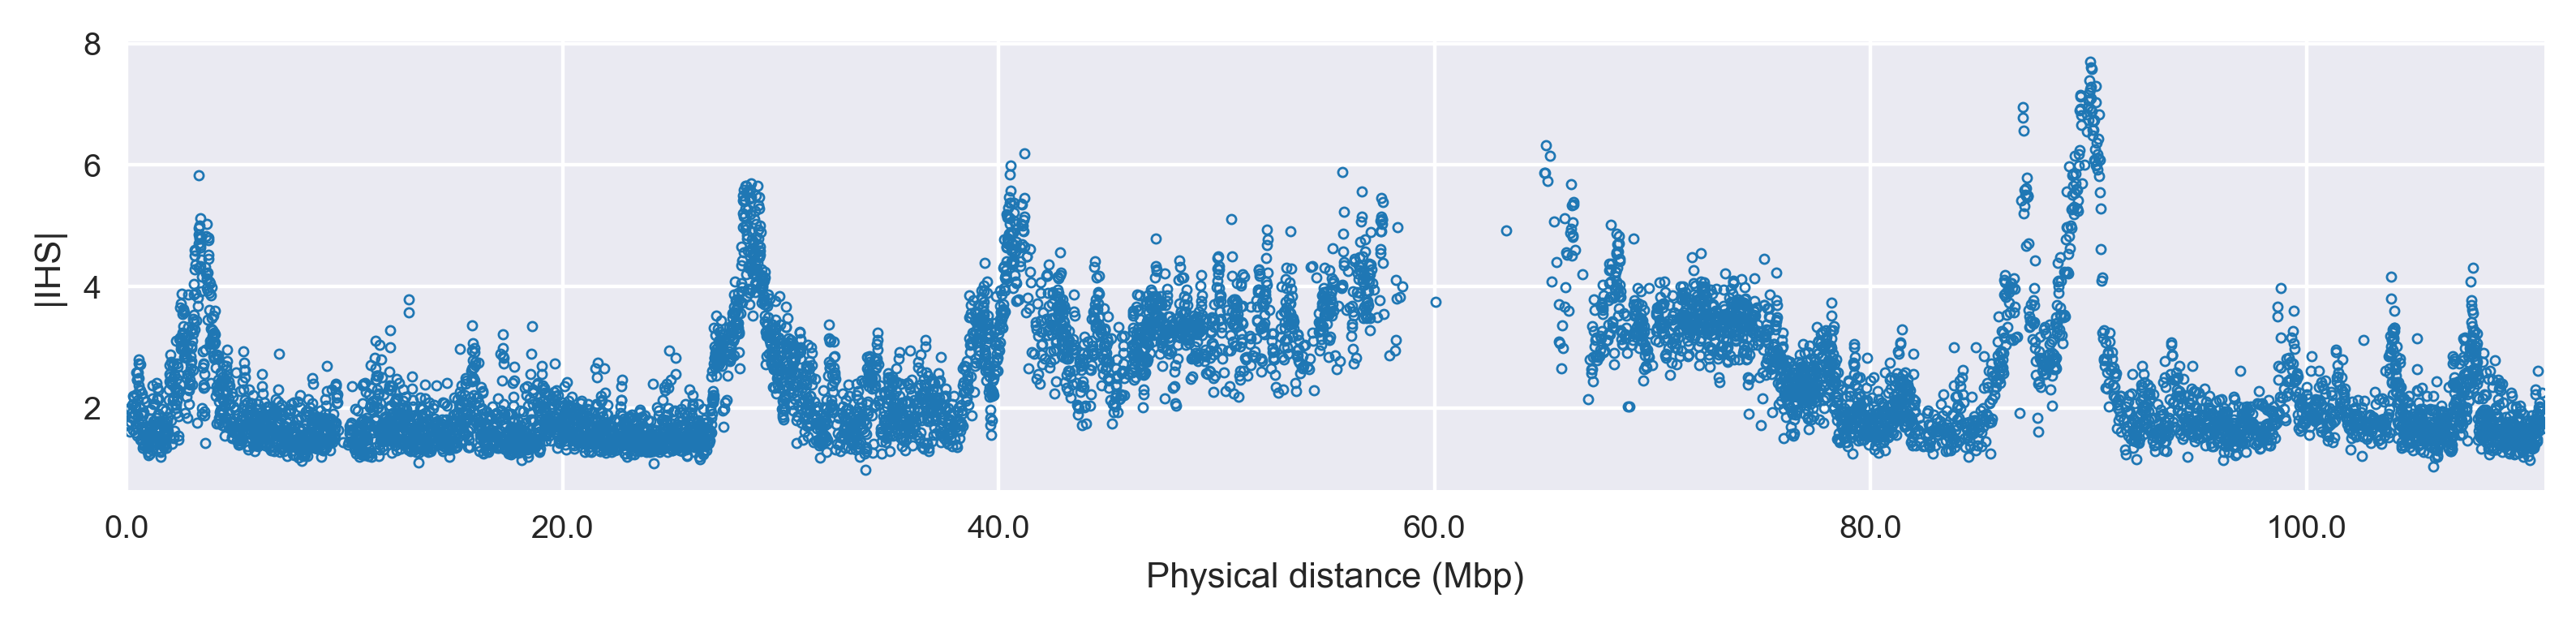

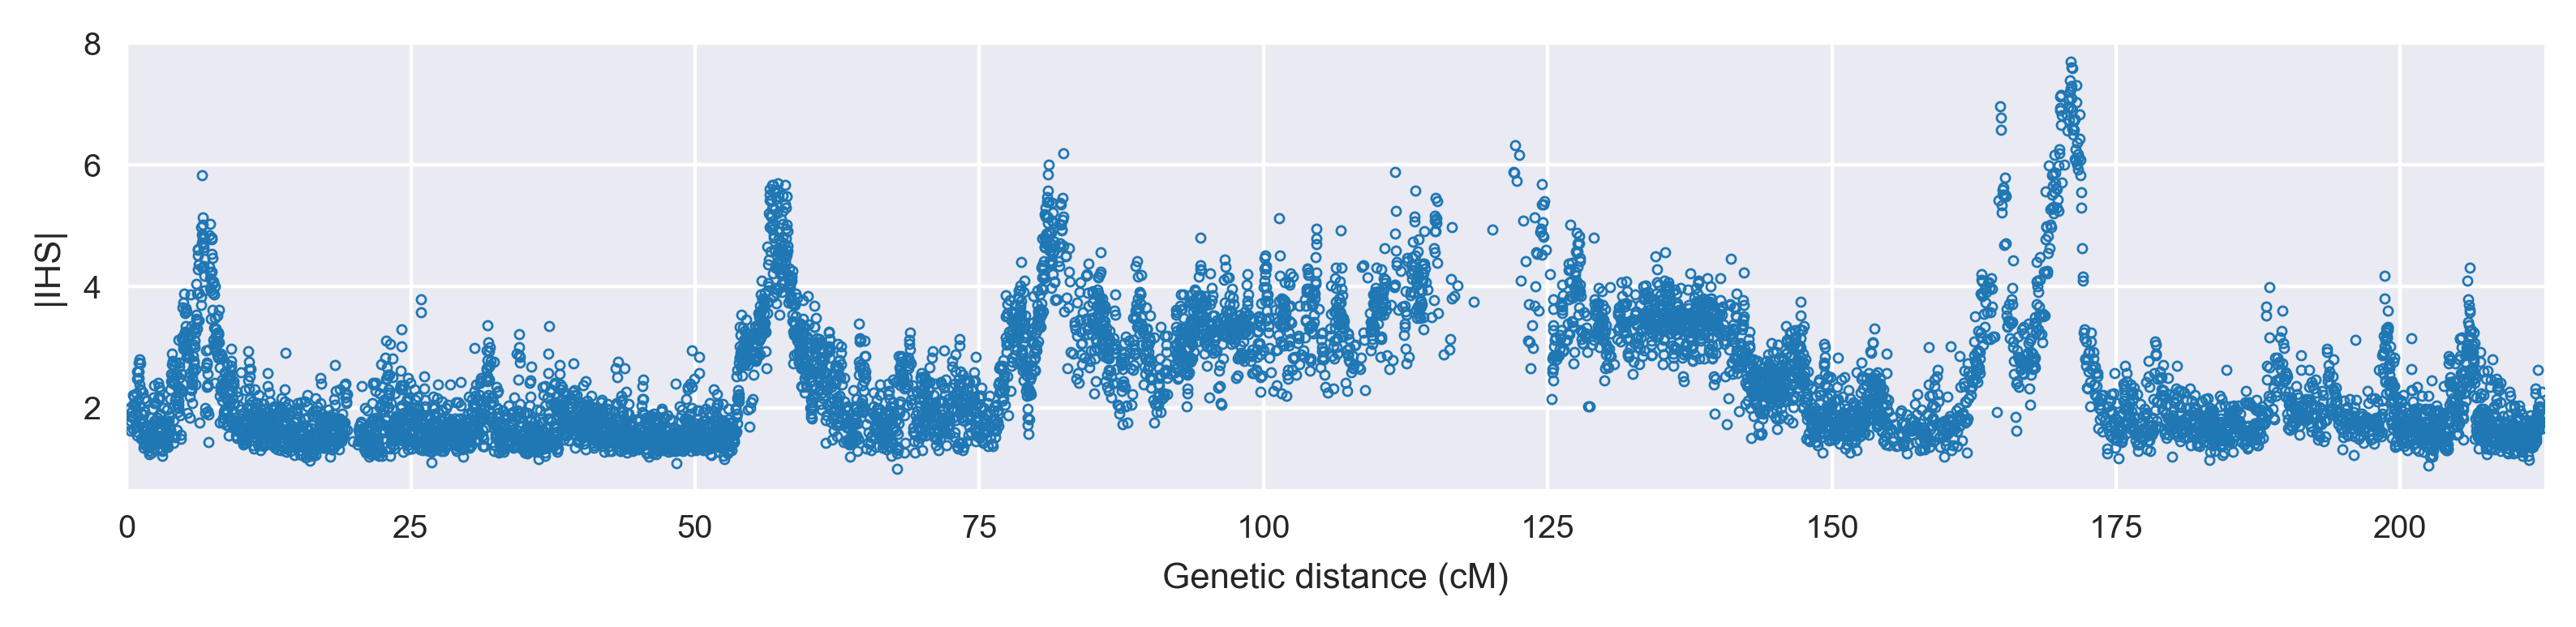

In [45]:
peakfit.plot_windowed_values(starts, ends, values, ylabel='|IHS|');
peakfit.plot_windowed_values(starts, ends, values, ylabel='|IHS|', gmap=gmap['2']);

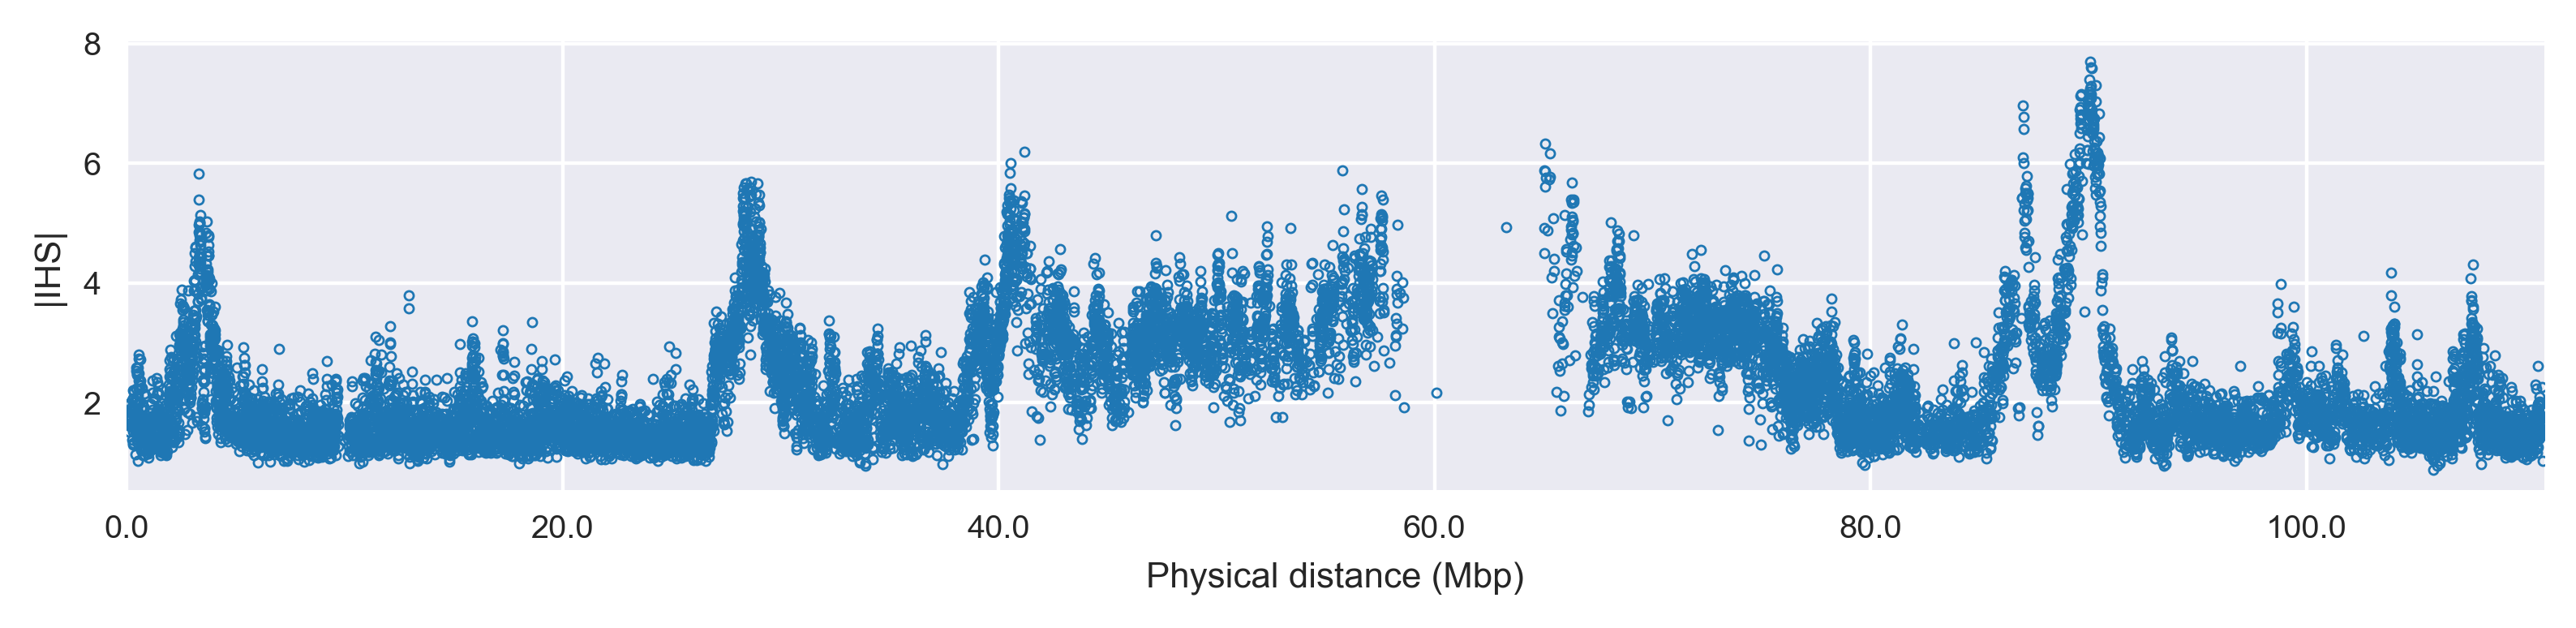

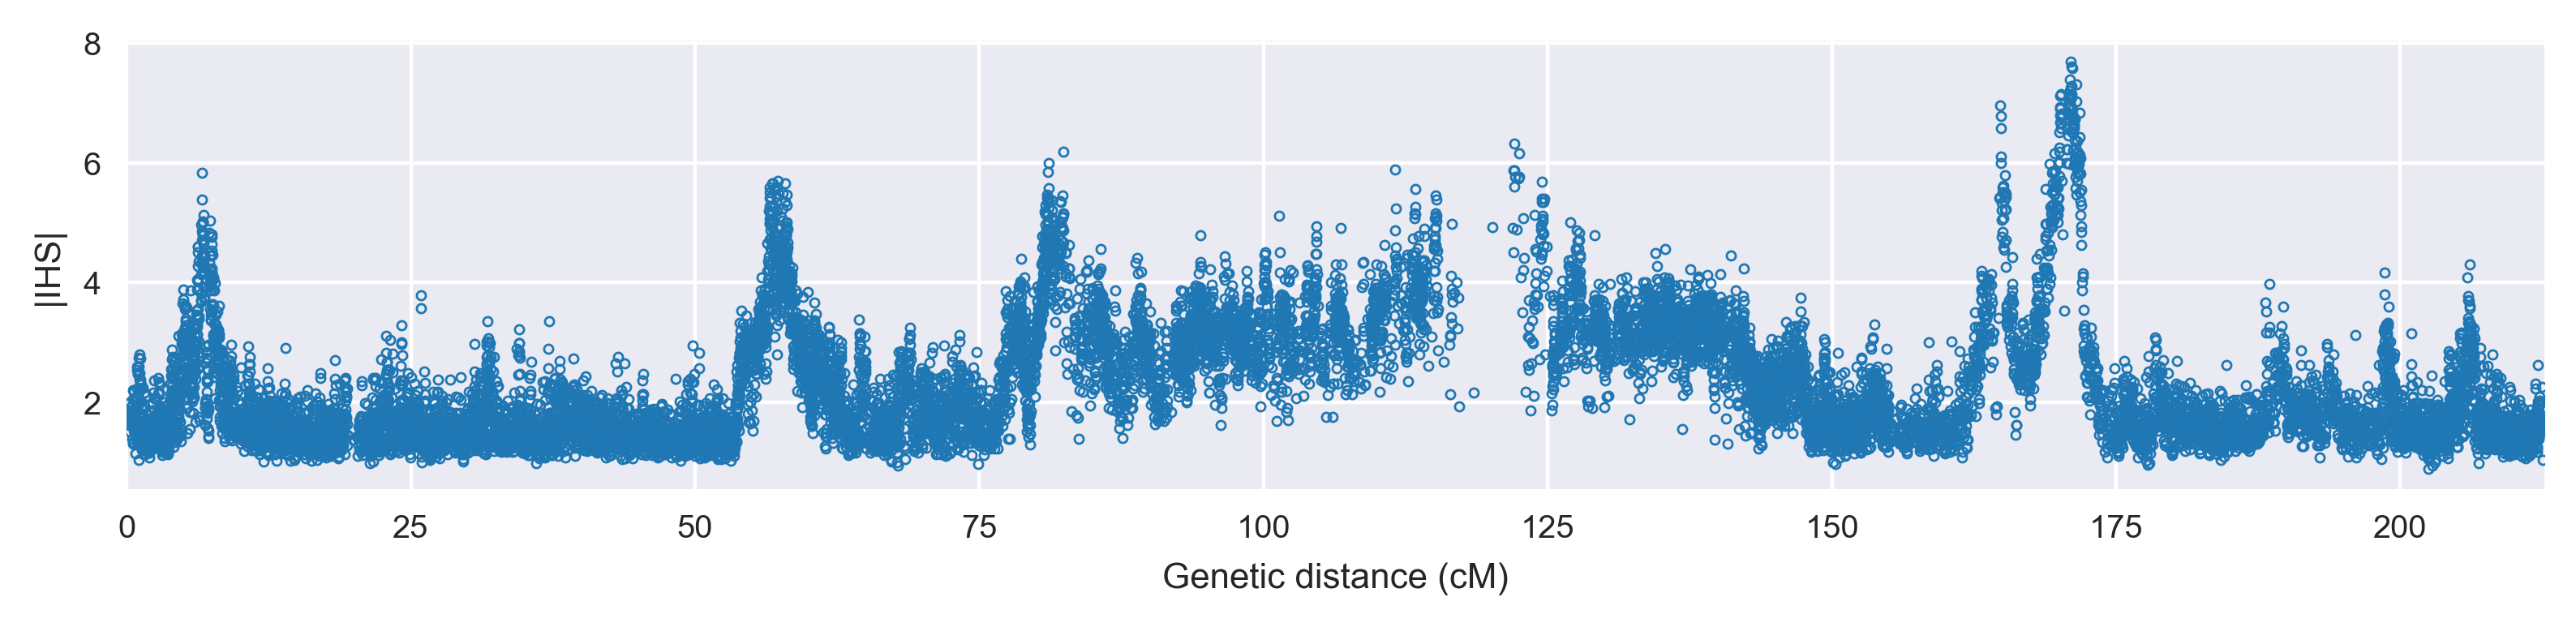

In [48]:
peakfit.plot_windowed_values(starts, ends, values, ylabel='|IHS|');
peakfit.plot_windowed_values(starts, ends, values, ylabel='|IHS|', gmap=gmap['2']);

In [11]:
idx_pop = df_haps[df_haps.population == 'BFS'].index.values
idx_pop

array([  0,   1,  28,  29,  30,  31,  44,  45,  46,  47,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 172, 173, 174, 175, 176, 177, 178, 179, 184, 185, 190, 191,
       206, 207, 210, 211, 212, 213, 216, 217, 218, 219, 222, 223, 224,
       225, 228, 229, 234, 235, 242, 243, 244, 245, 246, 247, 248, 249,
       254, 255, 256, 257, 262, 263, 264, 265, 270, 271, 272, 273, 274,
       275, 276, 277, 278, 279, 280, 281, 284, 285, 286, 287, 290, 291,
       292, 293, 296, 297, 298, 299])

In [15]:
haps_pop = allel.GenotypeDaskArray(callset_phased['X/calldata/genotype']).to_haplotypes().take(idx_pop, axis=1)
haps_pop

<HaplotypeDaskArray shape=(4219279, 162) dtype=int8>

In [16]:
ac_pop = haps_pop.count_alleles(max_allele=1).compute()
ac_pop

<AlleleCountsArray shape=(4219279, 2) dtype=int64>
161   1
161   1
160   2
...
162   0
140  22
112  50

In [17]:
ac_pop.to_frequencies()

array([[ 0.99382716,  0.00617284],
       [ 0.99382716,  0.00617284],
       [ 0.98765432,  0.01234568],
       ..., 
       [ 1.        ,  0.        ],
       [ 0.86419753,  0.13580247],
       [ 0.69135802,  0.30864198]])

In [18]:
loc_min_ac = (ac_pop.to_frequencies().min(axis=1) > 0.05) 

In [19]:
np.count_nonzero(loc_min_ac)

193842

In [20]:
haps_pop_min_ac = haps_pop.compress(loc_min_ac, axis=0).compute()
haps_pop_min_ac

/home/aliman/src/github/malariagen/agam-selection-atlas/deps/conda/envs/agam-selection-atlas/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


<HaplotypeArray shape=(193842, 162) dtype=int8>
1 0 0 0 0 ... 0 1 0 1 1
1 0 0 0 0 ... 0 1 0 1 1
1 0 0 0 0 ... 0 1 0 1 1
...
1 1 1 1 1 ... 1 1 1 1 1
0 0 0 0 0 ... 0 0 0 0 0
1 0 1 0 0 ... 0 1 0 0 1

In [22]:
pos = callset_phased['X/variants/POS'][:]
pos

array([      49,       80,      110, ..., 24316819, 24333445, 24334916], dtype=int32)

In [23]:
pos_min_ac = pos[loc_min_ac]
pos_min_ac.shape

(193842,)

In [24]:
gmap['X']

array([  2.00000000e-06,   4.00000000e-06,   6.00000000e-06, ...,
         4.22111975e+01,   4.22111980e+01,   4.22111985e+01])

In [25]:
gpos_min_ac = gmap['X'].take(pos_min_ac - 1)
gpos_min_ac

array([  4.94000000e-04,   4.74000000e-03,   5.79000000e-03, ...,
         4.21730130e+01,   4.21813670e+01,   4.21821025e+01])

In [26]:
ihs_phy = allel.ihs(haps_pop_min_ac, pos_min_ac, include_edges=True)

In [27]:
ihs_gen = allel.ihs(haps_pop_min_ac, pos_min_ac, map_pos=gpos_min_ac, include_edges=True)

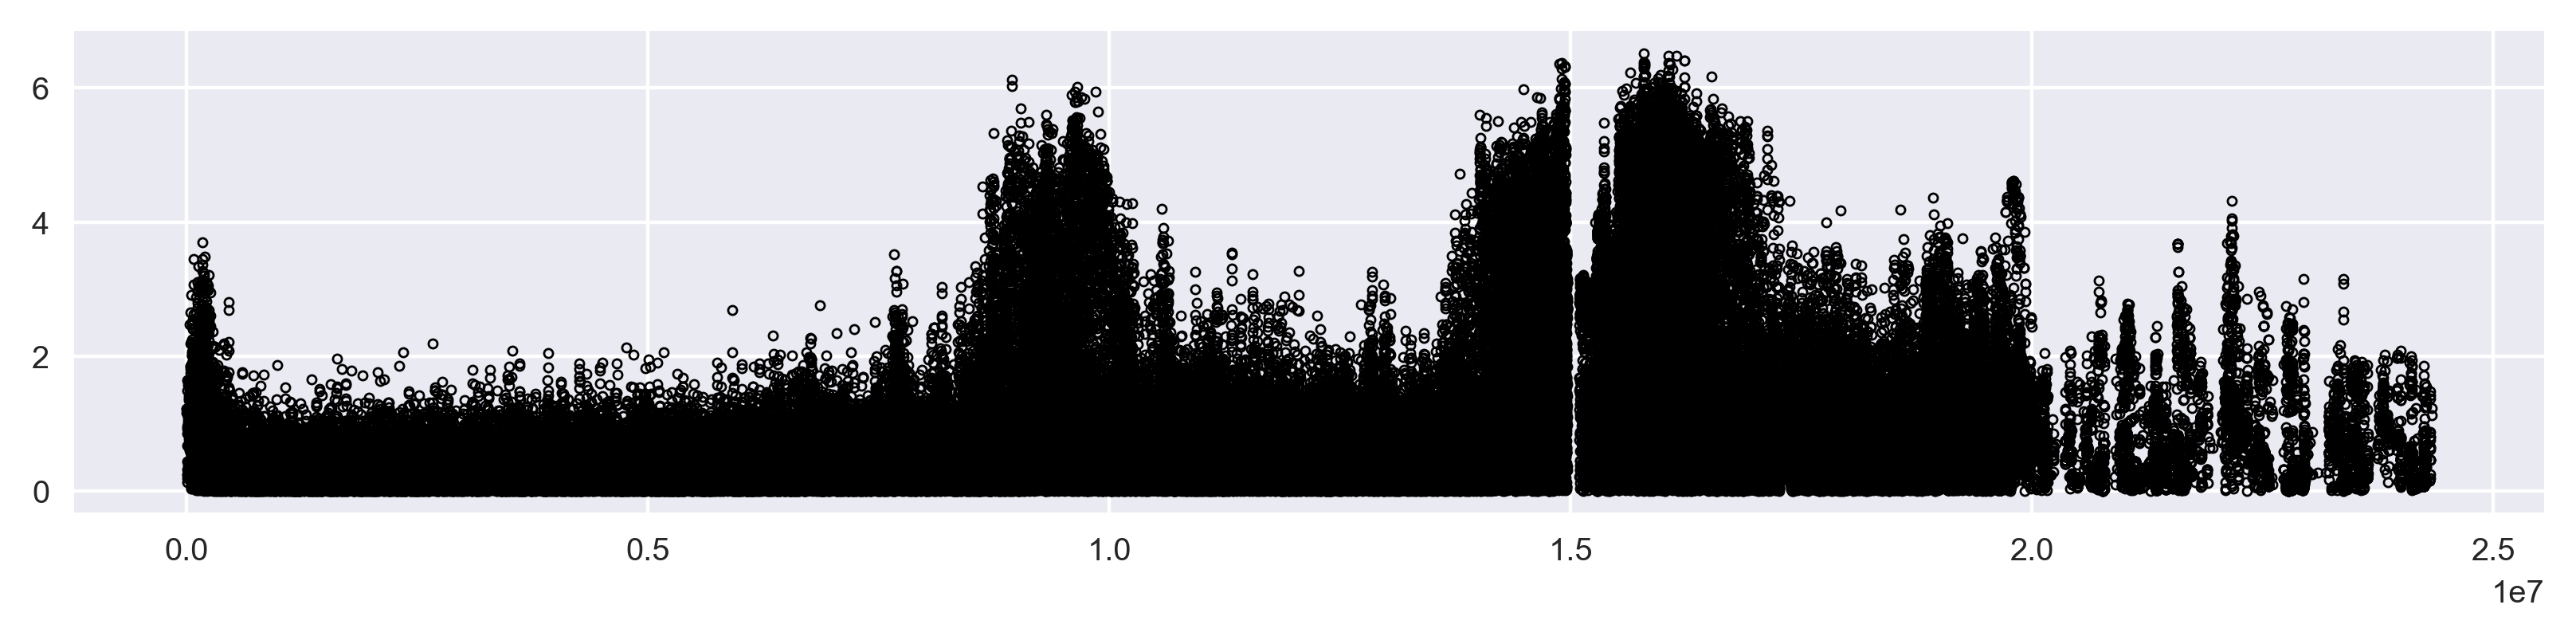

In [32]:
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(pos_min_ac, np.abs(ihs_phy), marker='o', linestyle=' ', mfc='none', mec='k', mew='.5', markersize=2);

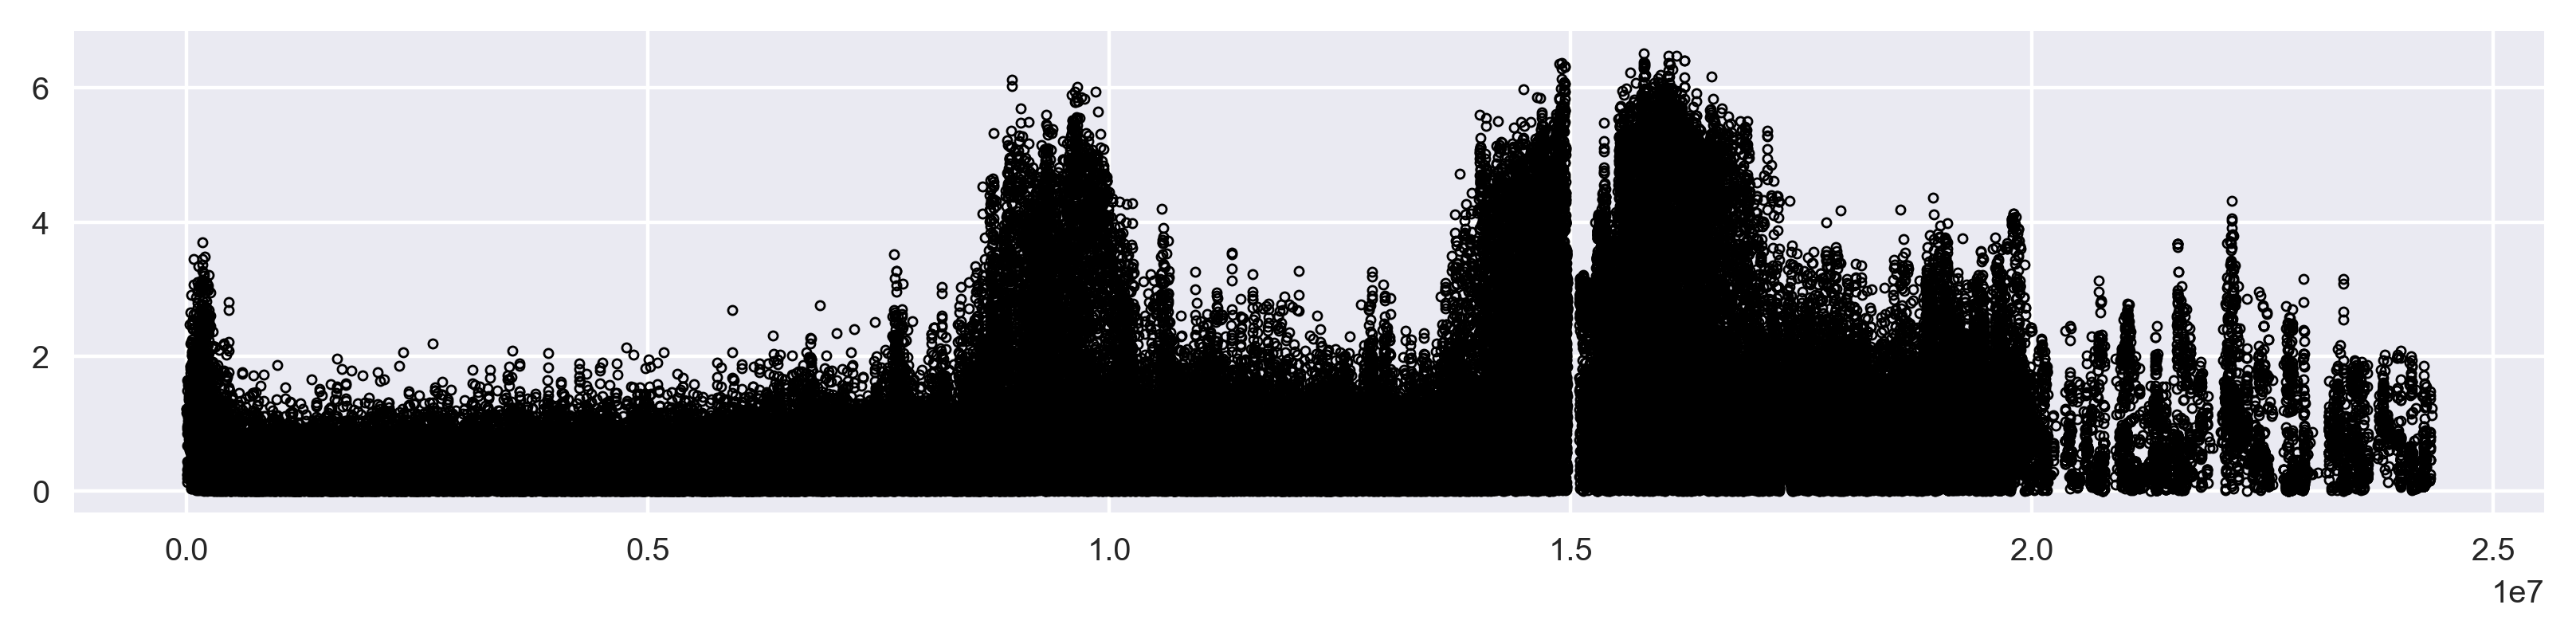

In [33]:
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(pos_min_ac, np.abs(ihs_gen), marker='o', linestyle=' ', mfc='none', mec='k', mew='.5', markersize=2);

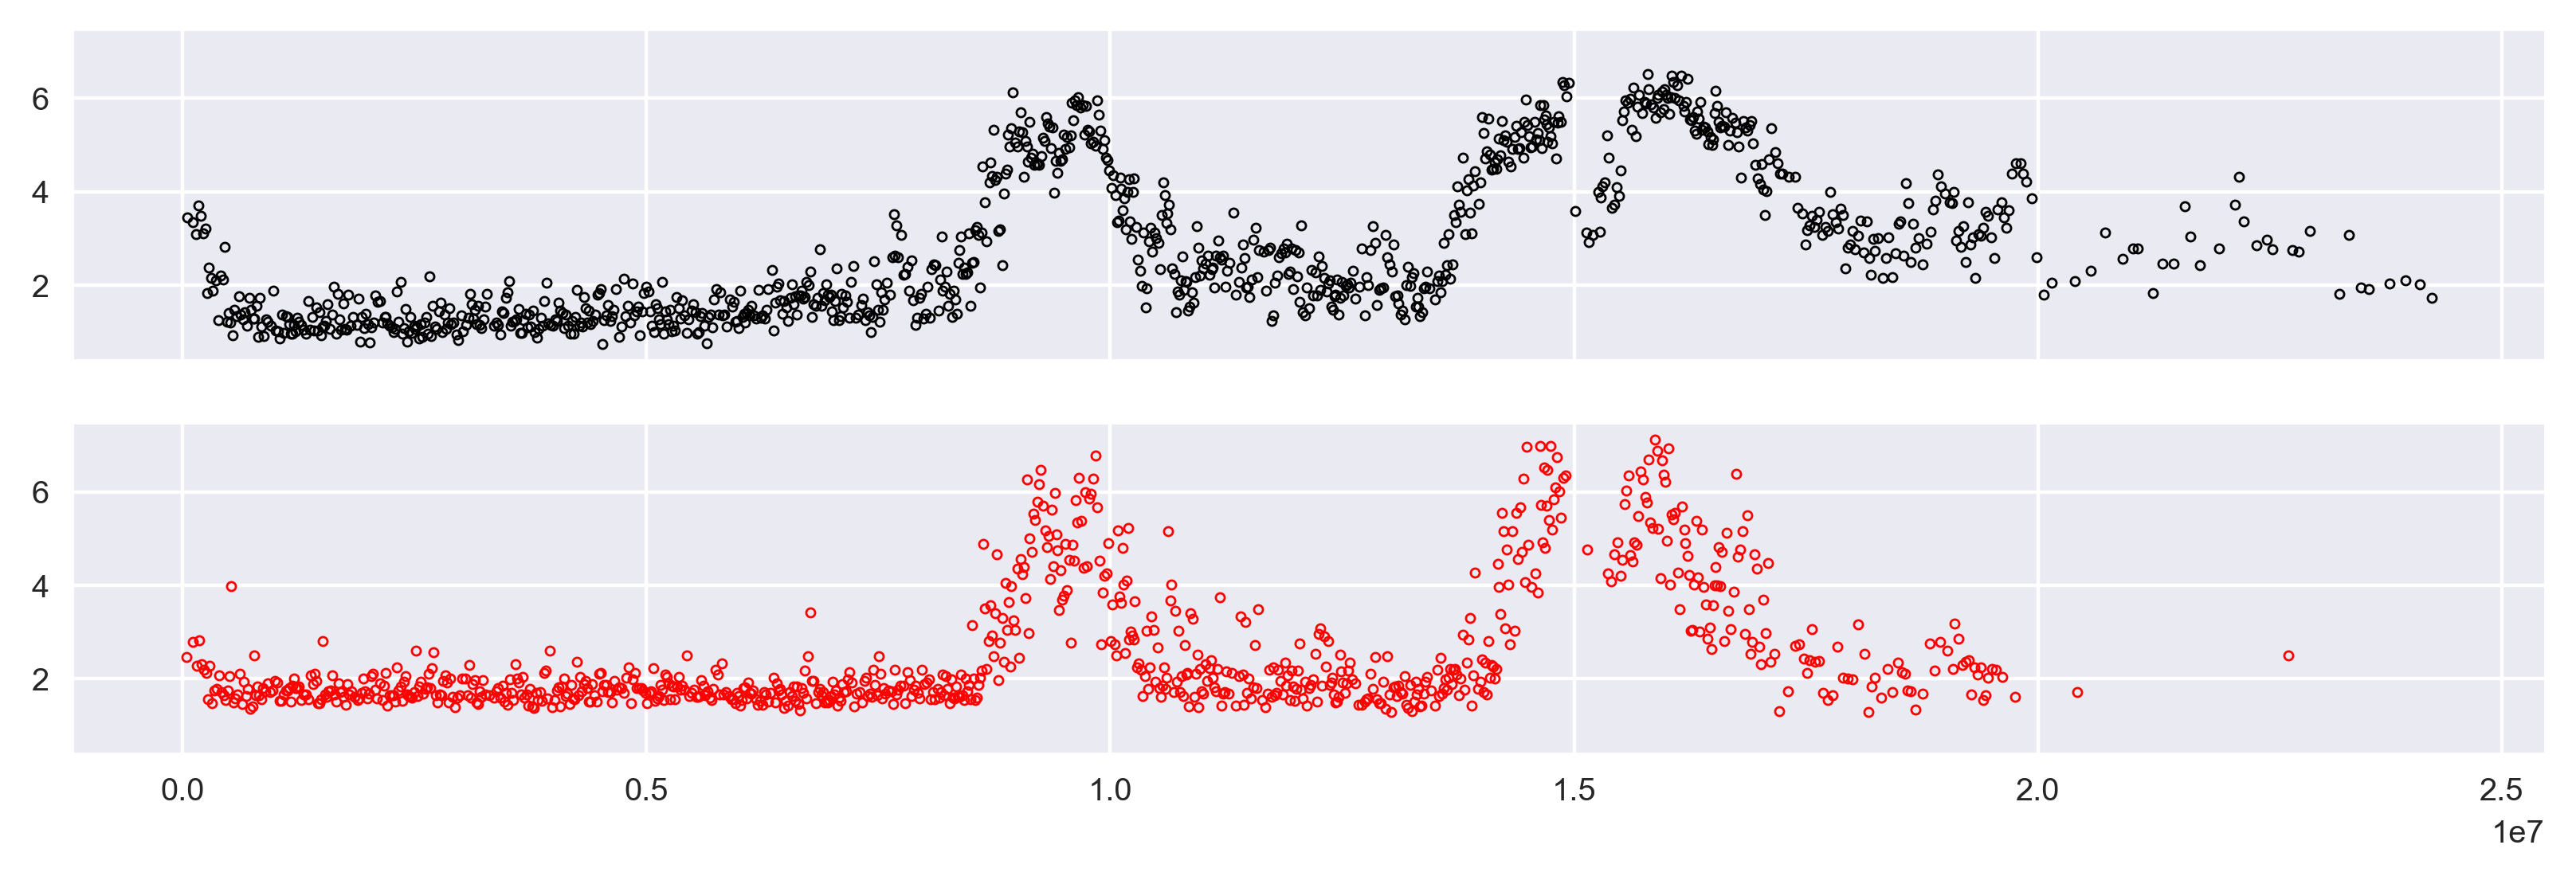

In [37]:
# construct moving windows
seqid = 'X'
window_size = 200
x = allel.moving_statistic(pos_min_ac, statistic=np.mean, size=window_size)
y = allel.moving_statistic(ihs_phy, statistic=np.max, size=window_size)
fig, axs = plt.subplots(nrows=2, figsize=(10, 3), sharex=True, sharey=True)
ax = axs[0]
ax.plot(x, y, marker='o', linestyle=' ', mfc='none', mec='k', mew='.5', markersize=2)
starts, ends, values, percentiles = peakfit.extract_windowed_values(df, seqid='X', genome=genome)
x = (starts + ends) / 2
y = values
ax = axs[1]
ax.plot(x, y, marker='o', linestyle=' ', mfc='none', mec='r', mew='.5', markersize=2);